# Analysing and controlling our model zoos

In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from zoo_utils import load_hyperrep_edx
from model_distances import compute_predictions, epsilon_delta_distance, distance_matrix

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
EXPERIMENT_PATH = Path.cwd() / 'results' / 'zoo_analysis'

if not EXPERIMENT_PATH.is_dir():
    os.makedirs(EXPERIMENT_PATH)

## Hyperparameters

In [6]:
RERUN = False

In [7]:
ZOO_PATHS = {
    'SVHN': Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/svhn_train_zoo_relu'),
    'CIFAR-10': Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/cifar10_train_zoo_relu'),
    'EuroSAT': Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/eurosat_train_zoo_relu')
}

TESTSETS = {
    'SVHN': torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt')['testset'],
    'CIFAR-10': torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt')['testset'],
    'EuroSAT': torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt')['testset']
}

## Visualising zoo performance

In [8]:
DF_ZOO_PATH = EXPERIMENT_PATH / 'df_zoo.csv'

if not DF_ZOO_PATH.is_file() or RERUN:
    df_zoo = pd.DataFrame(columns=[
        'Model zoo',
        'Trial ID',
        'Activation function',
        'Initialisation',
        'Learning rate',
        'Weight decay',
        'Seed',
        'Epoch',
        'Test accuracy',
        'Generalisation gap'
    ])

    for zoo_label, zoo_path in ZOO_PATHS.items():
        for path in os.listdir(zoo_path):
            if not re.match('NN_tune', path):
                continue
            path = zoo_path / path

            with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
                config = json.load(ifh_config)
                result = pd.read_json(ifh_result, lines=True)

            for edx in range(len(result)):
                df_zoo.loc[len(df_zoo)] = (
                    zoo_label,
                    result.loc[edx]['trial_id'],
                    config['model::nlin'],
                    config['model::init_type'],
                    config['optim::lr'],
                    config['optim::wd'],
                    config['seed'],
                    result.loc[edx]['training_iteration'],
                    result.loc[edx]['test_acc'],
                    result.loc[edx]['train_acc'] - result.loc[edx]['test_acc']
                )
            
    df_zoo.to_csv(DF_ZOO_PATH)

df_zoo = pd.read_csv(DF_ZOO_PATH, index_col=0)
df_zoo.head()

,Model zoo,Trial ID,Activation function,Initialisation,Learning rate,Weight decay,Seed,Epoch,Test accuracy,Generalisation gap
0,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,0,0.071758,-0.001563
1,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,1,0.775200,-0.182034
2,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,2,0.829479,-0.016614
3,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,3,0.846381,-0.003682
4,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,4,0.848033,0.010410


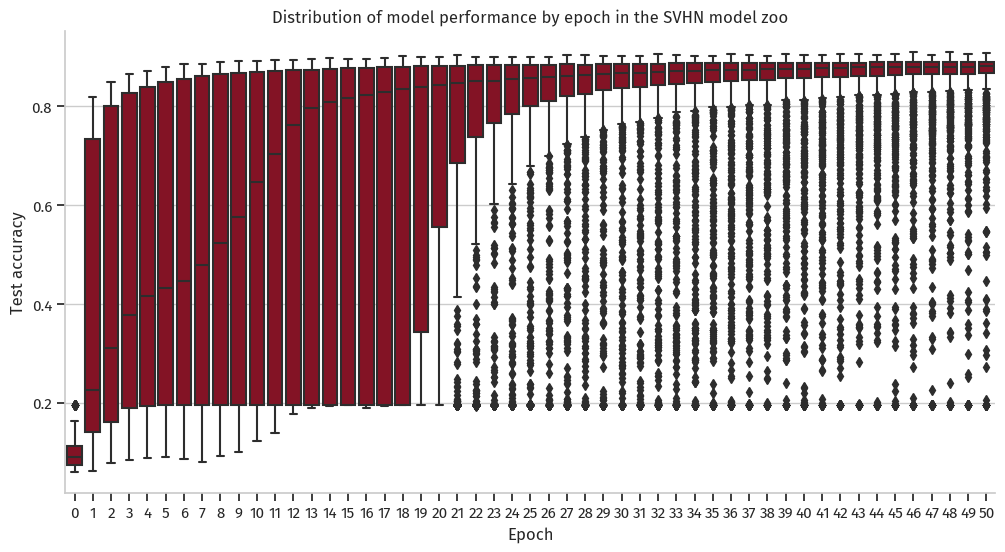

In [9]:
zoo_label = 'SVHN'

_, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(df_zoo[df_zoo['Model zoo'] == zoo_label], x='Epoch', y='Test accuracy', color=COLOURS[0], ax=ax).set(
    title=f'Distribution of model performance by epoch in the {zoo_label} model zoo'
)

plt.show()

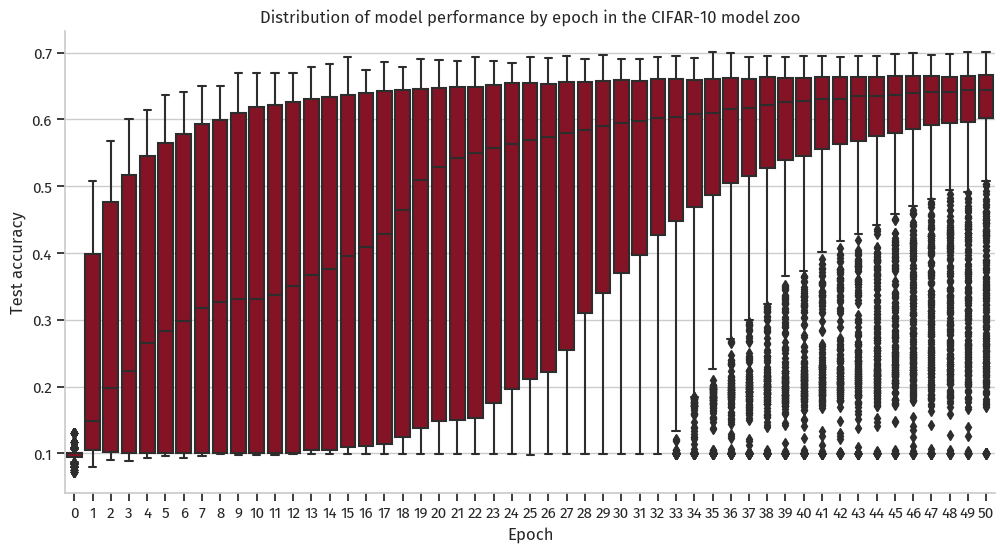

In [10]:
zoo_label = 'CIFAR-10'

_, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(df_zoo[df_zoo['Model zoo'] == zoo_label], x='Epoch', y='Test accuracy', color=COLOURS[0], ax=ax).set(
    title=f'Distribution of model performance by epoch in the {zoo_label} model zoo'
)

plt.show()

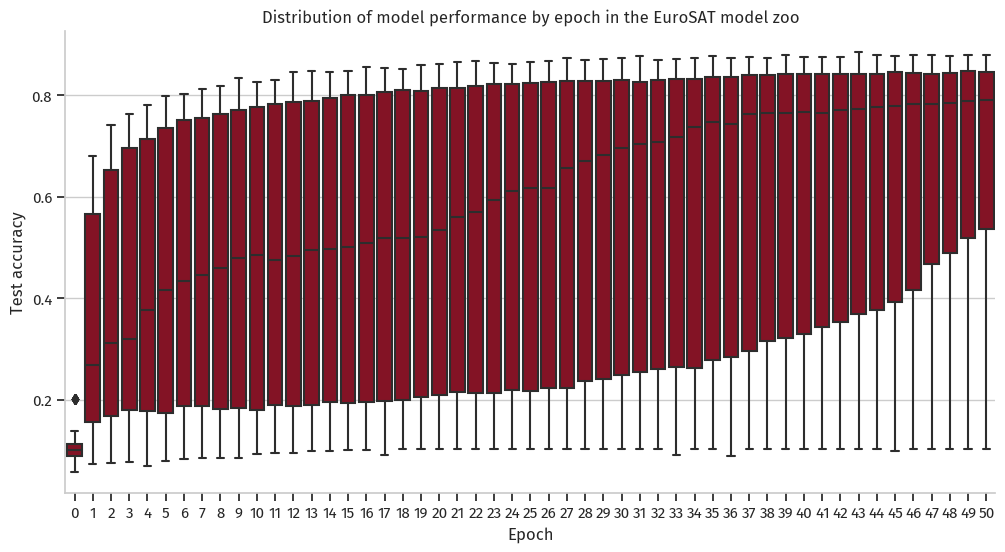

In [11]:
zoo_label = 'EuroSAT'

_, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(df_zoo[df_zoo['Model zoo'] == zoo_label], x='Epoch', y='Test accuracy', color=COLOURS[0], ax=ax).set(
    title=f'Distribution of model performance by epoch in the {zoo_label} model zoo'
)

plt.show()

### Compact figure

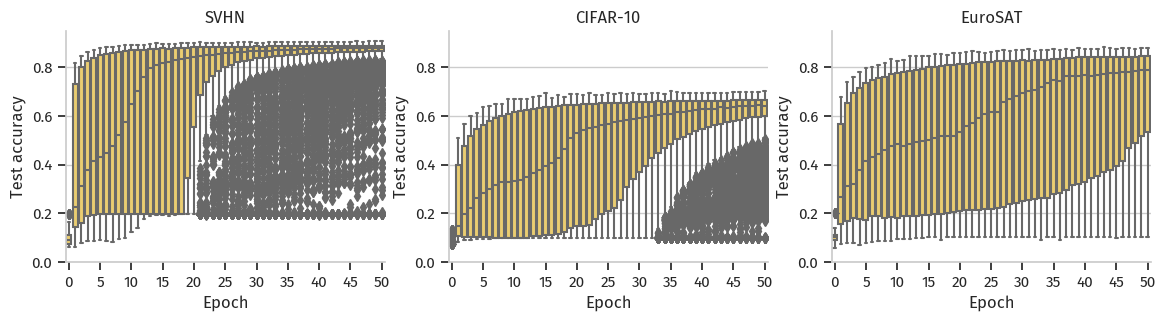

In [12]:
_, axs = plt.subplots(1, 3, sharey=False, figsize=(14, 3))

for i, zoo_label in enumerate(ZOO_PATHS.keys()):
    sns.boxplot(df_zoo[df_zoo['Model zoo'] == zoo_label], x='Epoch', y='Test accuracy', color=COLOURS[1], ax=axs[i]).set(
        title=zoo_label, ylim=(0., 0.95)
    )
    
    # Set the x-axis ticks to show only one every five ticks
    ticks = axs[i].get_xticks()
    axs[i].set_xticks(ticks[::5])

plt.savefig('figures/model_zoos_acc.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluating the eigendecomposition of model weights

In [13]:
def model_to_vector(model):
    # Get the state dictionary of the model
    state_dict = model.state_dict()
    # Flatten the state dictionary into a one-dimensional vector
    vector = np.concatenate([param.data.detach().cpu().numpy().flatten() for param in state_dict.values()])
    return vector

In [14]:
def vector_to_model(vector, device='cuda'):
    # Create a new instance of LeNet5
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    # Get the state dictionary of the model
    state_dict = model.state_dict()
    # Unflatten the vector into a state dictionary
    offset = 0
    for key, param in state_dict.items():
        size = np.prod(param.size())
        state_dict[key] = torch.from_numpy(vector[offset:offset+size].reshape(param.size()))
        offset += size
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    return model.to(device)

In [15]:
def test_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    device = next(model.parameters()).device

    with torch.no_grad():  # Disable gradient calculation to save memory
        for data in dataloader:
            images, labels = [tensor.to(device) for tensor in data]
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [16]:
# Loading reference checkpoint
zoo_path = ZOO_PATHS['SVHN']

for path in os.listdir(zoo_path):
    if 'NN_tune' in path and "_00000_0" in path:
        ref_path = zoo_path / path

with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
        
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))

In [17]:
DF_EIGEN_PATH = EXPERIMENT_PATH / 'df_eigen.csv'

if not DF_EIGEN_PATH.is_file() or RERUN:
    # Create dataframe
    df_eigen = pd.DataFrame(columns=['Model zoo', 'k', 'Explained variance', 'Selected eigenvalues', 'Reconstruction error', 'Average accuracy'])
    
    # Running experiments for every zoo
    for zoo_label, zoo_path in tqdm(ZOO_PATHS.items(), desc='Iterating through the 3 model zoos', unit='zoo', total=3):
        zoo_ds = torch.load(zoo_path / 'dataset_test.pt')
        zoo_dl = torch.utils.data.DataLoader(zoo_ds, batch_size=64, shuffle=False)
        
        dataloader = torch.utils.data.DataLoader(TESTSETS[zoo_label], batch_size=128, shuffle=False)
    
        X = list()

        # Run experiments
        for bdx, data in enumerate(zoo_dl):
            x, _, p, _ = data

            for idx in range(x.shape[0]):
                # Get original model
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)

                X.append(model_to_vector(orig_model))

        X = np.vstack(X)

        # Step 1: Center and scale the data using StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Step 2: Compute the covariance matrix
        cov_matrix = np.cov(X_scaled, rowvar=False)

        # Step 3: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Step 4: Sort eigenvalues and eigenvectors
        sorted_indices = np.argsort(eigenvalues)
        eigenvalues_sorted = eigenvalues[sorted_indices]
        eigenvectors_sorted = eigenvectors[:, sorted_indices]

        # Step 5: Compute explained variance
        total_variance = np.sum(eigenvalues_sorted)
        explained_variance = eigenvalues_sorted / total_variance

        # Step 6: Select k for specific explained variance levels
        explained_variance_levels = [x/10 for x in range(1, 10)]
        k_values = []
        for level in explained_variance_levels:
            cumulative_variance = np.cumsum(explained_variance)
            k = np.searchsorted(cumulative_variance, level) + 1
            k_values.append(k)
        k_values.append(X.shape[1]) # We also want the full approximation as a baseline

        # Step 7: Repeat the process using the top eigenvalues
        sorted_indices_top = sorted_indices[::-1]
        eigenvalues_sorted_top = eigenvalues[sorted_indices_top]
        eigenvectors_sorted_top = eigenvectors[:, sorted_indices_top]

        explained_variance_top = eigenvalues_sorted_top / total_variance
        k_values_top = []
        for level in explained_variance_levels:
            cumulative_variance_top = np.cumsum(explained_variance_top)
            k_top = np.searchsorted(cumulative_variance_top, level) + 1
            k_values_top.append(k_top)
        k_values_top.append(X.shape[1])

        explained_variance_levels.append(1.0) # We add the label for full reconstruction

        # Step 8: Project and reconstruct data for each k value, compute accuracy
        for expl_var_idx, explained_variance_target in tqdm(enumerate(explained_variance_levels), desc=f'{zoo_label}: computing reconstructed accuracy', unit='experiment', total=len(explained_variance_levels)):
            # Bottom
            k = k_values[expl_var_idx]
            explained_variance_actual = np.sum(explained_variance[:k])
            selected_eigenvectors = eigenvectors_sorted[:, :k]
            X_projected = np.dot(X_scaled, selected_eigenvectors)
            X_reconstructed = np.dot(X_projected, selected_eigenvectors.T)
            X_reconstructed = scaler.inverse_transform(X_reconstructed)

            l2_bot = np.linalg.norm(X - X_reconstructed)
            acc_bot = list()

            for i in range(X.shape[0]):
                acc_bot.append(test_model(vector_to_model(X_reconstructed[i]), dataloader))

            df_eigen.loc[len(df_eigen)] = (
                zoo_label,
                k,
                explained_variance_actual,
                'Bottom',
                l2_bot,
                np.mean(acc_bot)
            )

            # Top
            k = k_values_top[expl_var_idx]
            explained_variance_actual = np.sum(explained_variance_top[:k])
            selected_eigenvectors_top = eigenvectors_sorted_top[:, :k]
            X_projected_top = np.dot(X_scaled, selected_eigenvectors_top)
            X_reconstructed_top = np.dot(X_projected_top, selected_eigenvectors_top.T)
            X_reconstructed_top = scaler.inverse_transform(X_reconstructed_top)

            l2_top = np.linalg.norm(X - X_reconstructed_top)
            acc_top = list()

            for i in range(X.shape[0]):
                acc_top.append(test_model(vector_to_model(X_reconstructed_top[i]), dataloader))

            df_eigen.loc[len(df_eigen)] = (
                zoo_label,
                k,
                explained_variance_actual,
                'Top',
                l2_top,
                np.mean(acc_top)
            )
            
            # Extremes
            if expl_var_idx == 9:
                df_eigen.loc[len(df_eigen)] = (
                    zoo_label,
                    k,
                    explained_variance_actual,
                    'Hybrid',
                    l2_top,
                    np.mean(acc_top)
                )
            elif expl_var_idx % 2 == 1:
                k_bot = k_values[expl_var_idx // 2]
                k_top = k_values_top[expl_var_idx // 2]
                k = k_bot + k_top
                
                explained_variance_actual = np.sum(explained_variance_top[-k_bot:]) + np.sum(explained_variance_top[:k_top])
                
                selected_eigenvectors = np.hstack((
                    eigenvectors_sorted_top[:, :k_top],
                    eigenvectors_sorted_top[:, -k_bot:]
                ))
                
                X_projected = np.dot(X_scaled, selected_eigenvectors)
                X_reconstructed = np.dot(X_projected, selected_eigenvectors.T)
                X_reconstructed = scaler.inverse_transform(X_reconstructed)
                
                l2_ext = np.linalg.norm(X - X_reconstructed)
                acc_ext = list()

                for i in range(X.shape[0]):
                    acc_ext.append(test_model(vector_to_model(X_reconstructed[i]), dataloader))

                df_eigen.loc[len(df_eigen)] = (
                    zoo_label,
                    k,
                    explained_variance_actual,
                    'Extremes',
                    l2_ext,
                    np.mean(acc_ext)
                )

    # Save results
    df_eigen.to_csv(DF_EIGEN_PATH)
    
df_eigen_small = pd.read_csv(DF_EIGEN_PATH, index_col=0)
df_eigen_small.head()

,Model zoo,k,Explained variance,Selected eigenvalues,Reconstruction error,Average accuracy
0,SVHN,10689,0.100304,Bottom,763.911083,0.206005
1,SVHN,2,0.137084,Top,749.162090,0.224545
2,SVHN,10757,0.200174,Bottom,720.509158,0.228431
3,SVHN,4,0.221497,Top,709.749607,0.217102
4,SVHN,10691,0.237388,Extremes,705.039311,0.306440


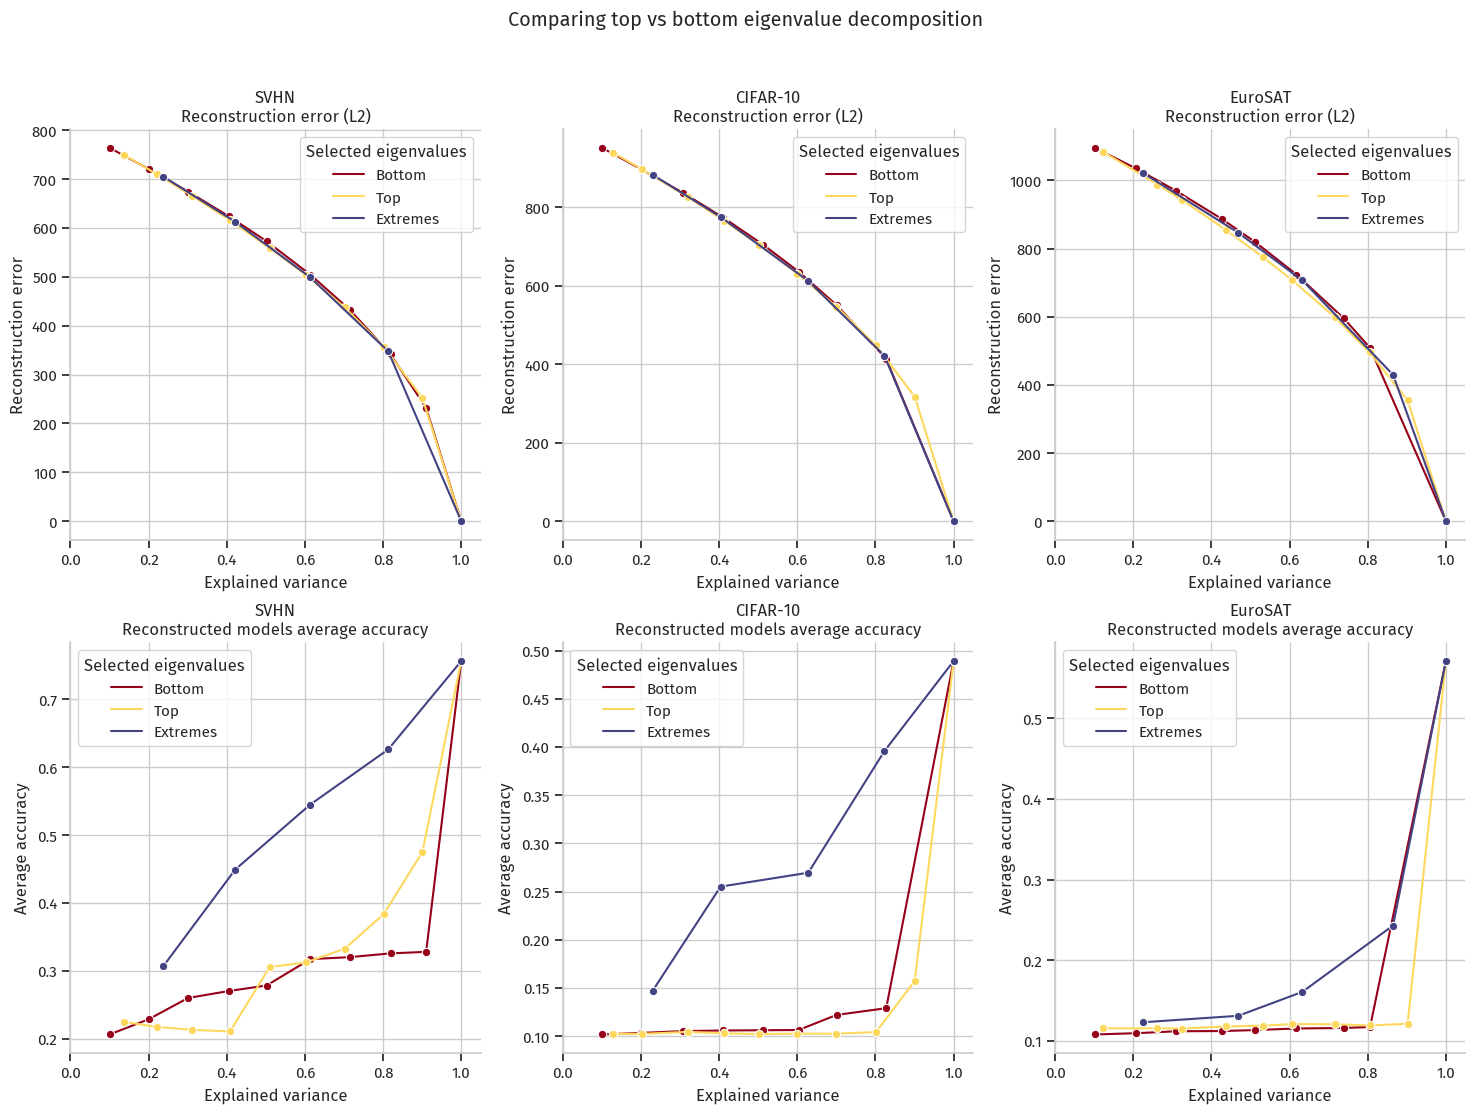

In [18]:
_, axs = plt.subplots(2, 3, figsize=(18, 12))

for z, zoo_label in enumerate(ZOO_PATHS.keys()):
    sns.lineplot(df_eigen_small[df_eigen_small['Model zoo'] == zoo_label], x='Explained variance', y='Reconstruction error', hue='Selected eigenvalues', palette=COLOURS[:3], marker="o", ax=axs[0][z])
    sns.lineplot(df_eigen_small[df_eigen_small['Model zoo'] == zoo_label], x='Explained variance', y='Average accuracy', hue='Selected eigenvalues', palette=COLOURS[:3], marker="o", ax=axs[1][z])

    axs[0][z].set(title=f'{zoo_label}\nReconstruction error (L2)', xlim=(0,1.05))
    axs[1][z].set(title=f'{zoo_label}\nReconstructed models average accuracy', xlim=(0,1.05))

plt.suptitle('Comparing top vs bottom eigenvalue decomposition')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [19]:
DF_EIGEN_LARGE_PATH = EXPERIMENT_PATH / 'df_eigen_large.csv'

if not DF_EIGEN_LARGE_PATH.is_file() or RERUN:
    # Create dataframe
    df_eigen = pd.DataFrame(columns=['Model zoo', 'k', 'Explained variance', 'Selected eigenvalues', 'Reconstruction error', 'Average accuracy'])
    
    # Running experiments for every zoo
    for zoo_label, zoo_path in tqdm(ZOO_PATHS.items(), desc='Iterating through the 3 model zoos', unit='zoo', total=3):
        zoo_ds = torch.load(zoo_path / 'dataset_train.pt')
        zoo_dl = torch.utils.data.DataLoader(zoo_ds, batch_size=64, shuffle=False)
        
        dataloader = torch.utils.data.DataLoader(TESTSETS[zoo_label], batch_size=128, shuffle=False)
    
        X = list()

        # Run experiments
        for bdx, data in enumerate(zoo_dl):
            x, _, p, _ = data

            for idx in range(x.shape[0]):
                # Get original model
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)

                X.append(model_to_vector(orig_model))

        X = np.vstack(X)

        # Step 1: Center and scale the data using StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Step 2: Compute the covariance matrix
        cov_matrix = np.cov(X_scaled, rowvar=False)

        # Step 3: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Step 4: Sort eigenvalues and eigenvectors
        sorted_indices = np.argsort(eigenvalues)
        eigenvalues_sorted = eigenvalues[sorted_indices]
        eigenvectors_sorted = eigenvectors[:, sorted_indices]

        # Step 5: Compute explained variance
        total_variance = np.sum(eigenvalues_sorted)
        explained_variance = eigenvalues_sorted / total_variance

        # Step 6: Select k for specific explained variance levels
        explained_variance_levels = [x/10 for x in range(1, 10)]
        k_values = []
        for level in explained_variance_levels:
            cumulative_variance = np.cumsum(explained_variance)
            k = np.searchsorted(cumulative_variance, level) + 1
            k_values.append(k)
        k_values.append(X.shape[1]) # We also want the full approximation as a baseline

        # Step 7: Repeat the process using the top eigenvalues
        sorted_indices_top = sorted_indices[::-1]
        eigenvalues_sorted_top = eigenvalues[sorted_indices_top]
        eigenvectors_sorted_top = eigenvectors[:, sorted_indices_top]

        explained_variance_top = eigenvalues_sorted_top / total_variance
        k_values_top = []
        for level in explained_variance_levels:
            cumulative_variance_top = np.cumsum(explained_variance_top)
            k_top = np.searchsorted(cumulative_variance_top, level) + 1
            k_values_top.append(k_top)
        k_values_top.append(X.shape[1])

        explained_variance_levels.append(1.0) # We add the label for full reconstruction

        # Step 8: Project and reconstruct data for each k value, compute accuracy
        for expl_var_idx, explained_variance_target in tqdm(enumerate(explained_variance_levels), desc=f'{zoo_label}: computing reconstructed accuracy', unit='experiment', total=len(explained_variance_levels)):
            # Bottom
            k = k_values[expl_var_idx]
            explained_variance_actual = np.sum(explained_variance[:k])
            selected_eigenvectors = eigenvectors_sorted[:, :k]
            X_projected = np.dot(X_scaled, selected_eigenvectors)
            X_reconstructed = np.dot(X_projected, selected_eigenvectors.T)
            X_reconstructed = scaler.inverse_transform(X_reconstructed)

            l2_bot = np.linalg.norm(X - X_reconstructed)
            acc_bot = list()

            for i in range(X.shape[0]):
                acc_bot.append(test_model(vector_to_model(X_reconstructed[i]), dataloader))

            df_eigen.loc[len(df_eigen)] = (
                zoo_label,
                k,
                explained_variance_actual,
                'Bottom',
                l2_bot,
                np.mean(acc_bot)
            )

            # Top
            k = k_values_top[expl_var_idx]
            explained_variance_actual = np.sum(explained_variance_top[:k])
            selected_eigenvectors_top = eigenvectors_sorted_top[:, :k]
            X_projected_top = np.dot(X_scaled, selected_eigenvectors_top)
            X_reconstructed_top = np.dot(X_projected_top, selected_eigenvectors_top.T)
            X_reconstructed_top = scaler.inverse_transform(X_reconstructed_top)

            l2_top = np.linalg.norm(X - X_reconstructed_top)
            acc_top = list()

            for i in range(X.shape[0]):
                acc_top.append(test_model(vector_to_model(X_reconstructed_top[i]), dataloader))

            df_eigen.loc[len(df_eigen)] = (
                zoo_label,
                k,
                explained_variance_actual,
                'Top',
                l2_top,
                np.mean(acc_top)
            )
            
            # Extremes
            if expl_var_idx == 9:
                df_eigen.loc[len(df_eigen)] = (
                    zoo_label,
                    k,
                    explained_variance_actual,
                    'Hybrid',
                    l2_top,
                    np.mean(acc_top)
                )
            elif expl_var_idx % 2 == 1:
                k_bot = k_values[expl_var_idx // 2]
                k_top = k_values_top[expl_var_idx // 2]
                k = k_bot + k_top
                
                explained_variance_actual = np.sum(explained_variance_top[-k_bot:]) + np.sum(explained_variance_top[:k_top])
                
                selected_eigenvectors = np.hstack((
                    eigenvectors_sorted_top[:, :k_top],
                    eigenvectors_sorted_top[:, -k_bot:]
                ))
                
                X_projected = np.dot(X_scaled, selected_eigenvectors)
                X_reconstructed = np.dot(X_projected, selected_eigenvectors.T)
                X_reconstructed = scaler.inverse_transform(X_reconstructed)
                
                l2_ext = np.linalg.norm(X - X_reconstructed)
                acc_ext = list()

                for i in range(X.shape[0]):
                    acc_ext.append(test_model(vector_to_model(X_reconstructed[i]), dataloader))

                df_eigen.loc[len(df_eigen)] = (
                    zoo_label,
                    k,
                    explained_variance_actual,
                    'Extremes',
                    l2_ext,
                    np.mean(acc_ext)
                )

    # Save results
    df_eigen.to_csv(DF_EIGEN_LARGE_PATH)
    
df_eigen_large = pd.read_csv(DF_EIGEN_LARGE_PATH, index_col=0)
df_eigen_large.head()

,Model zoo,k,Explained variance,Selected eigenvalues,Reconstruction error,Average accuracy
0,SVHN,10074,0.100038,Bottom,1876.993939,0.185673
1,SVHN,2,0.106798,Top,1873.017565,0.227617
2,SVHN,10426,0.200019,Bottom,1769.319689,0.187757
3,SVHN,14,0.203883,Top,1766.370188,0.314731
4,SVHN,10076,0.206836,Extremes,1765.586348,0.233233


In [20]:
df_eigen_large['Selected eigenvalues'] = df_eigen_large['Selected eigenvalues'].map({
    'Top': 'Top',
    'Bottom': 'Bottom',
    'Extremes': 'Hybrid'
})

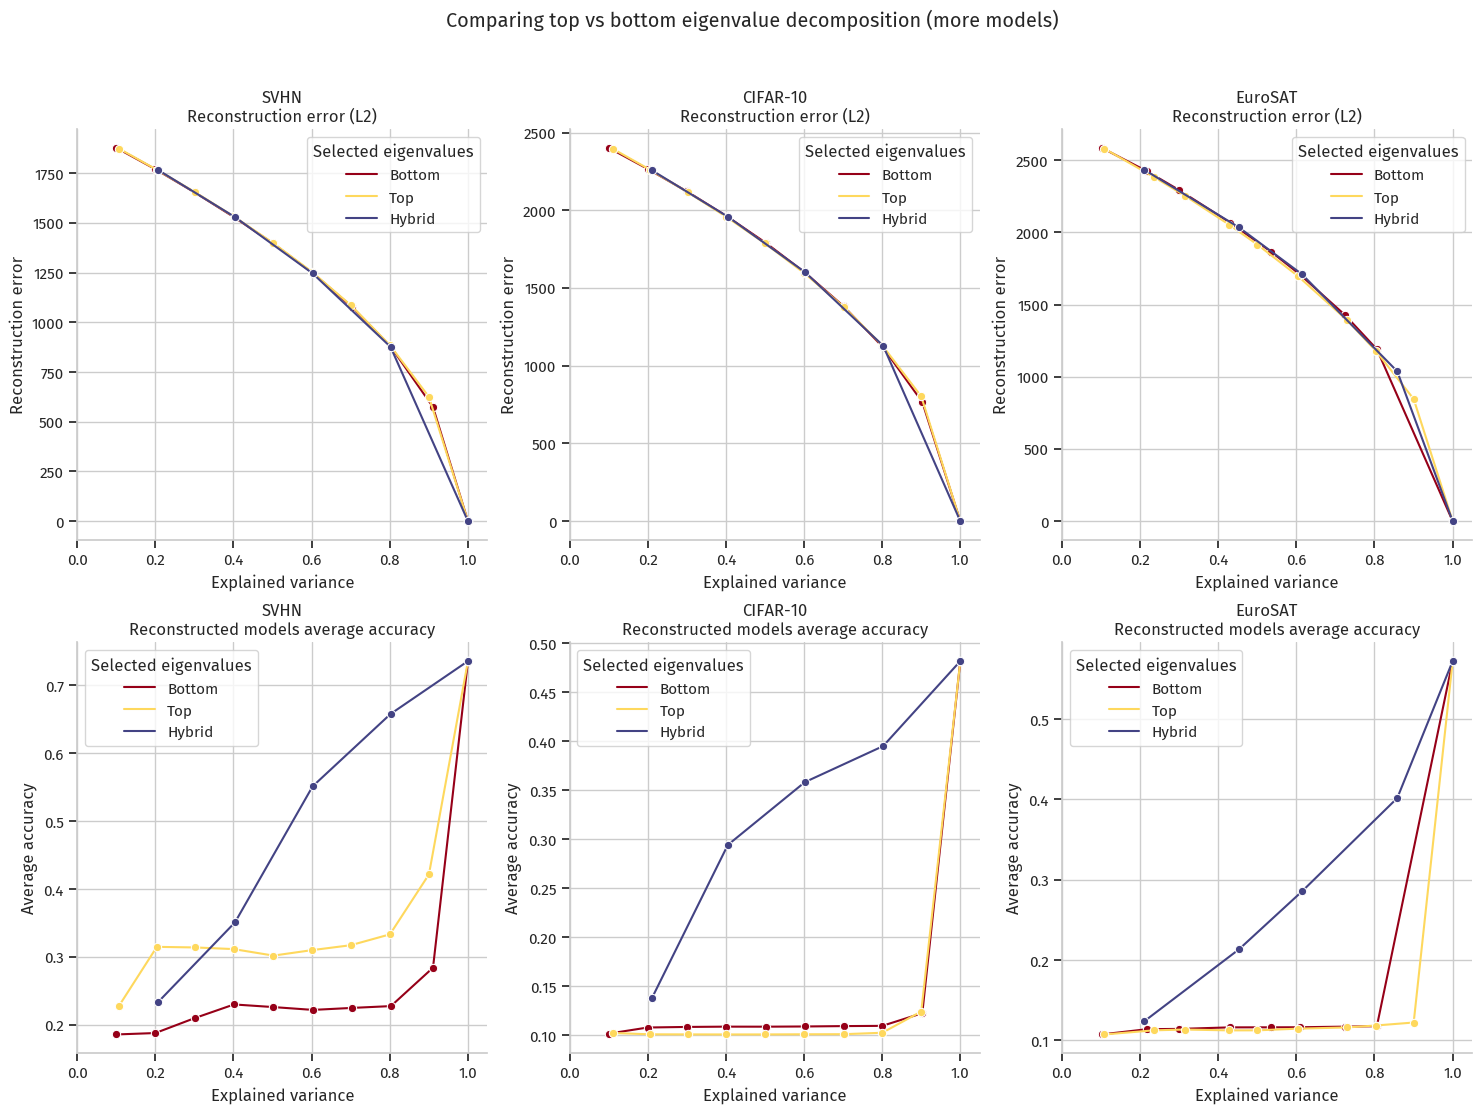

In [21]:
_, axs = plt.subplots(2, 3, figsize=(18, 12))

for z, zoo_label in enumerate(ZOO_PATHS.keys()):
    sns.lineplot(df_eigen_large[df_eigen_large['Model zoo'] == zoo_label], x='Explained variance', y='Reconstruction error', hue='Selected eigenvalues', palette=COLOURS[:3], marker="o", ax=axs[0][z])
    sns.lineplot(df_eigen_large[df_eigen_large['Model zoo'] == zoo_label], x='Explained variance', y='Average accuracy', hue='Selected eigenvalues', palette=COLOURS[:3], marker="o", ax=axs[1][z])

    axs[0][z].set(title=f'{zoo_label}\nReconstruction error (L2)', xlim=(0,1.05))
    axs[1][z].set(title=f'{zoo_label}\nReconstructed models average accuracy', xlim=(0,1.05))

plt.suptitle('Comparing top vs bottom eigenvalue decomposition (more models)')
plt.subplots_adjust(hspace=0.25)
plt.show()

#### Generating a Figure for the paper

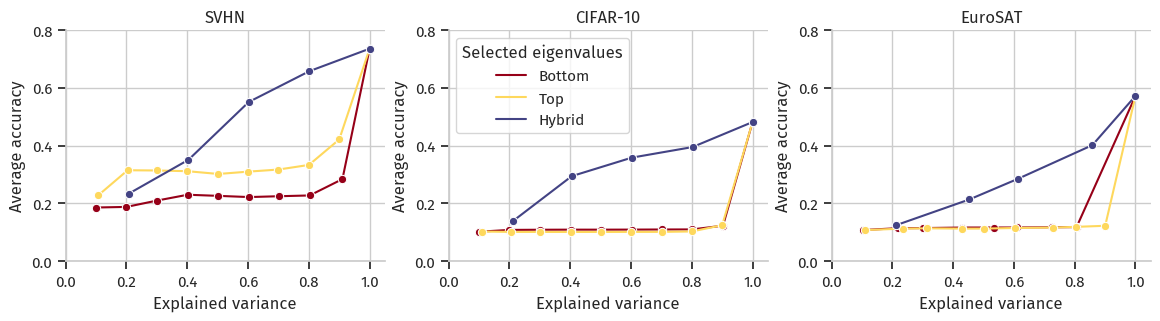

In [24]:
_, axs = plt.subplots(1, 3, figsize=(14, 3))

for z, zoo_label in enumerate(ZOO_PATHS.keys()):
    sns.lineplot(df_eigen_large[df_eigen_large['Model zoo'] == zoo_label], x='Explained variance', y='Average accuracy', hue='Selected eigenvalues', palette=COLOURS[:3], marker="o", ax=axs[z])
    axs[z].set(title=f"{zoo_label}", xlim=(0,1.05), ylim=(0., 0.8))
    if z != 1:
        axs[z].get_legend().remove()
    
plt.savefig('figures/eigendecomposition_reconstruction.png', dpi=300, bbox_inches='tight')
plt.show()